In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

In [2]:
# Install required libs

### please update Albumentations to latest version for `Lambda` transform support
# !pip install -U git+https://github.com/albu/albumentations 
# !pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [4]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

In [5]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [6]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [8]:
def fix_mask(mask):
    mask_min = mask.min()
    mask_max = mask.max()
    if mask_min == mask_max:
        return np.zeros_like(mask)
    mask[mask == mask_max] = 1
    mask[mask != 1] = 0
    return mask

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            mask = fix_mask(mask)
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            mask = fix_mask(mask)
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

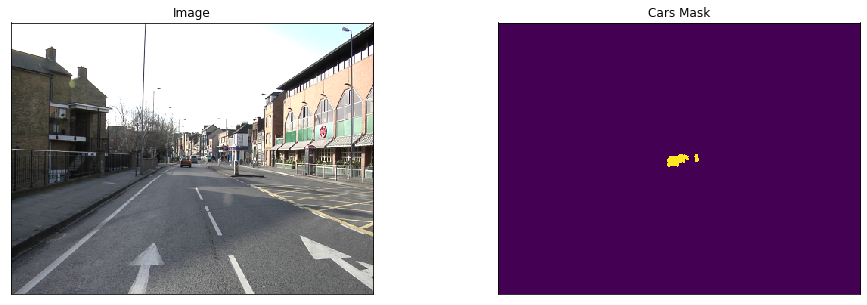

In [9]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['car'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [10]:
import albumentations as albu

In [11]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

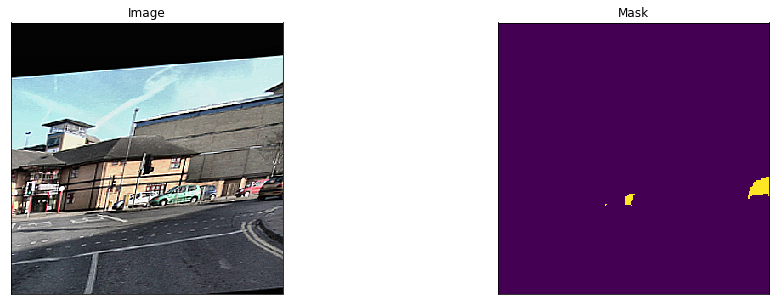

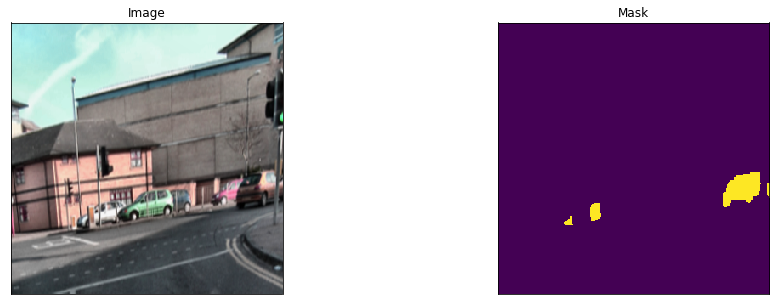

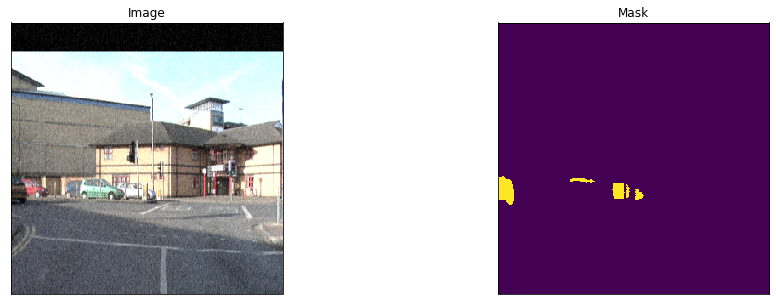

In [12]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['car'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

## Create model and train

In [13]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [14]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'
CLASSES = ['car']
ACTIVATION = 'sigmoid'
# create segmentation model with pretrained encoder
unet_model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
unet_model.name = 'unet'
from torch import from_numpy
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [15]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)
from custom_pytorch.custom_losses import DilatedCEDiceLoss
loss = DilatedCEDiceLoss()
# loss = smp.utils.losses.BCEDiceLoss(eps=1.)
metrics = [
        smp.utils.metrics.IoUMetric(eps=1.),
        smp.utils.metrics.FscoreMetric(eps=1.),
    ]

/home/vaslem/Code/kaggle/.venv/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2107: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


In [16]:

def train_model(model, batch_size=8):
    # Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
    # IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12)
    valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)
    


    optimizer = torch.optim.Adam([
        {'params': model.decoder.parameters(), 'lr': 1e-4}, 

        # decrease lr for encoder in order not to permute 
        # pre-trained weights with large gradients on training start
        {'params': model.encoder.parameters(), 'lr': 1e-6},  
    ])

    # create epoch runners 
    # it is a simple loop of iterating over dataloader`s samples
    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=DEVICE,
        verbose=True,
    )

    valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=DEVICE,
        verbose=True,
    )

    # train model for 40 epochs

    max_score = 0

    for i in range(0, 40):
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)

        # do something (save model, change lr, etc.)
        if max_score < valid_logs['iou']:
            max_score = valid_logs['iou']
            torch.save(model, f'./best_model_{model.name}.pth')
            print('Model saved!')

        if i == 25:
            optimizer.param_groups[0]['lr'] = 1e-5
            print('Decrease decoder learning rate to 1e-5!')


In [17]:
train_model(unet_model)


Epoch: 0
valid: 100%|██████████| 101/101 [00:03<00:00, 31.96it/s, dilated_ce_dice_loss - 20.72, iou - 0.03741, f-score - 0.06895]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:03<00:00, 32.02it/s, dilated_ce_dice_loss - 19.61, iou - 0.08567, f-score - 0.1455]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:03<00:00, 30.94it/s, dilated_ce_dice_loss - 19.18, iou - 0.1298, f-score - 0.2045]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:03<00:00, 31.41it/s, dilated_ce_dice_loss - 18.02, iou - 0.1312, f-score - 0.2084]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:03<00:00, 30.92it/s, dilated_ce_dice_loss - 17.25, iou - 0.1107, f-score - 0.1817]

Epoch: 5
valid: 100%|██████████| 101/101 [00:03<00:00, 29.22it/s, dilated_ce_dice_loss - 14.29, iou - 0.07277, f-score - 0.1254]

Epoch: 6
valid: 100%|██████████| 101/101 [00:03<00:00, 31.66it/s, dilated_ce_dice_loss - 11.6, iou - 0.0482, f-score - 0.08704] 

Epoch: 7
valid: 100%|██████████| 101/10

KeyboardInterrupt: 

In [ ]:
model.name

## Test best saved model

In [ ]:
# load best saved checkpoint
best_model = torch.load('./best_model_unet.pth')
best_model.encoder_features_method = '__call__'
from torch import nn
best_model.activation = nn.Sigmoid()

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

## Visualize predictions

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().numpy().round()
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )